 Load Preprocessed Data

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load preprocessed credit card data
credit_df = pd.read_csv("../data/creditcard_ready.csv")
print("✅ Loaded credit card dataset.")


✅ Loaded credit card dataset.


Train-Test Split

In [2]:
# Split features and target
X = credit_df.drop(columns=['Class'])
y = credit_df['Class']

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Fraud ratio in train: {y_train.mean():.4f}, in test: {y_test.mean():.4f}")


Train shape: (226980, 30), Test shape: (56746, 30)
Fraud ratio in train: 0.0017, in test: 0.0017


Apply SMOTE

In [3]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("✅ SMOTE applied.")
print(f"Original train counts:\n{y_train.value_counts().to_dict()}")
print(f"Balanced train counts:\n{y_train_balanced.value_counts().to_dict()}")


✅ SMOTE applied.
Original train counts:
{0: 226602, 1: 378}
Balanced train counts:
{0: 226602, 1: 226602}


Evaluate Helper from model_utils.py

In [5]:
import sys
import os

# Add src to path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))

from model_utils import evaluate_model

Logistic Regression

📊 Evaluation for Logistic Regression:
F1 Score: 0.09747504403992954
Precision: 0.05161691542288557
Recall: 0.8736842105263158
AUC-PR: 0.6737248276914044


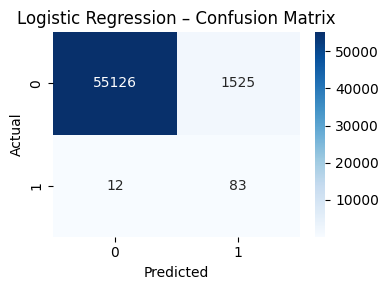


Classification Report:
              precision    recall  f1-score   support

           0     0.9998    0.9731    0.9863     56651
           1     0.0516    0.8737    0.0975        95

    accuracy                         0.9729     56746
   macro avg     0.5257    0.9234    0.5419     56746
weighted avg     0.9982    0.9729    0.9848     56746



In [6]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_balanced, y_train_balanced)

evaluate_model(lr_model, X_test, y_test, model_name="Logistic Regression")


XGBoost Classifier

c:\Users\filimon.hailemariam\Downloads\Week 8&9\fraud-detection-ecommerce-banking\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:56:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


📊 Evaluation for XGBoost:
F1 Score: 0.5284280936454849
Precision: 0.3872549019607843
Recall: 0.8315789473684211
AUC-PR: 0.8015810356785698


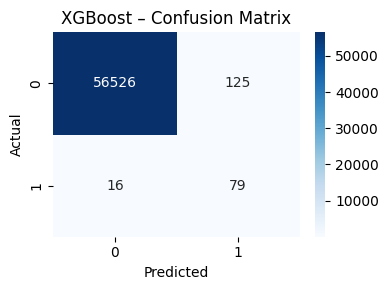


Classification Report:
              precision    recall  f1-score   support

           0     0.9997    0.9978    0.9988     56651
           1     0.3873    0.8316    0.5284        95

    accuracy                         0.9975     56746
   macro avg     0.6935    0.9147    0.7636     56746
weighted avg     0.9987    0.9975    0.9980     56746



In [7]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    scale_pos_weight=1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train_balanced, y_train_balanced)

evaluate_model(xgb_model, X_test, y_test, model_name="XGBoost")


Random Forest

📊 Evaluation for Random Forest:
F1 Score: 0.6784140969162996
Precision: 0.5833333333333334
Recall: 0.8105263157894737
AUC-PR: 0.7778610497531913


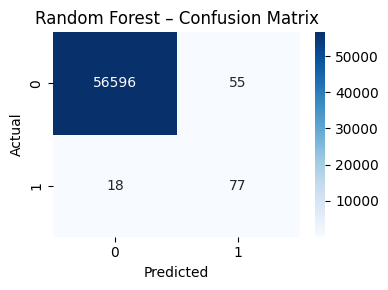


Classification Report:
              precision    recall  f1-score   support

           0     0.9997    0.9990    0.9994     56651
           1     0.5833    0.8105    0.6784        95

    accuracy                         0.9987     56746
   macro avg     0.7915    0.9048    0.8389     56746
weighted avg     0.9990    0.9987    0.9988     56746



In [8]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_balanced, y_train_balanced)

evaluate_model(rf_model, X_test, y_test, model_name="Random Forest")


In [9]:
from sklearn.metrics import f1_score, precision_score, recall_score, average_precision_score

def get_scores(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    return {
        "Model": name,
        "F1 Score": f1_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "AUC-PR": average_precision_score(y_test, y_prob) if y_prob is not None else None
    }

results = [
    get_scores(lr_model, X_test, y_test, "Logistic Regression"),
    get_scores(xgb_model, X_test, y_test, "XGBoost"),
    get_scores(rf_model, X_test, y_test, "Random Forest"),
]

results_df = pd.DataFrame(results).sort_values(by="F1 Score", ascending=False)
display(results_df)


,Model,F1 Score,Precision,Recall,AUC-PR
2,Random Forest,0.678414,0.583333,0.810526,0.777861
1,XGBoost,0.528428,0.387255,0.831579,0.801581
0,Logistic Regression,0.097475,0.051617,0.873684,0.673725



🧠 Key Insights
Random Forest offers the best overall trade-off:

Highest F1 Score (0.6784): Best balance between precision and recall.

Highest Precision (0.5833): More trustworthy positive (fraud) predictions.

Solid AUC-PR (0.7779): Performs well in ranking frauds in imbalanced data.

XGBoost has:

Best Recall (0.8316): Catches the most fraud cases.

Best AUC-PR (0.8016): Excellent at separating fraud from non-fraud.

But lower precision (0.3873): More false positives than Random Forest.

Logistic Regression underperforms:

Very low F1 (0.0975) and precision (0.05): Most fraud predictions are incorrect.

Despite a high recall (0.87), it’s not practically useful due to high false alarms.

✅ Recommendation
🔥 Choose Random Forest for deployment.

Best balance between fraud detection and reliability.

Lower false positives than XGBoost.

Easier to interpret and faster to train than boosting models.

Suitable for real-time risk flags without overwhelming the fraud team.